In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [4]:
# Read Weekly Customer complaints, with week as datetime index
df = pd.read_csv('weekly_customer_complaints.csv', index_col='week', parse_dates=True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [5]:
# Rename the "complaints" column to "y" for convenience
df = df.rename(columns={"complaints": "y"})
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [6]:
# Get info about the DataFrame (column types, missing values, etc.)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   y                        261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [7]:
# Remove commas from the "y" column and convert it to integer type
df["y"] = df["y"].str.replace(",", "").astype(int)
df.head()

,y,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26%,1,0,0
2018-01-08,1701,35.38%,0,0,0
2018-01-15,1711,36.22%,1,0,0
2018-01-22,1443,38.33%,1,0,0
2018-01-29,1397,36.34%,0,0,0


# Data Visualization 

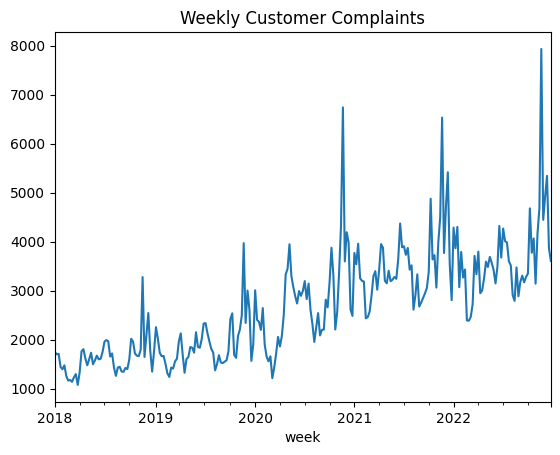

In [8]:
# Basic time series plot of the weekly complaints
df["y"].plot(title="Weekly Customer Complaints")
plt.show()

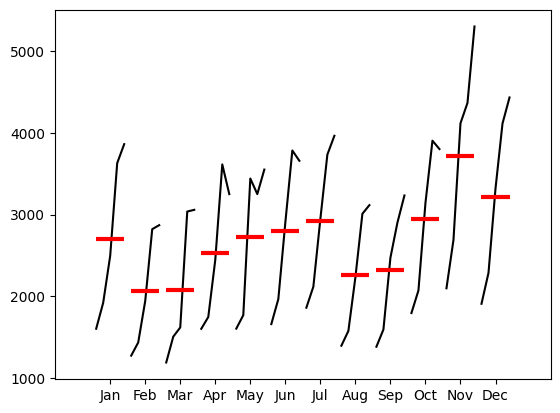

In [10]:
# Resample the data monthly (month-end) and plot each month separately to observe patterns
# As per the output, the mean of the complaints changes over months and is not stationary

month_plot(df['y'].resample('ME').mean())
plt.show()

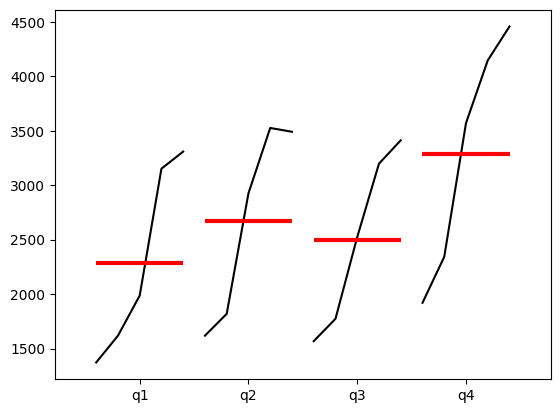

In [12]:
# Resample quarterly (quarter-end) and plot to see the quarterly seasonality
# This output shows the complaints increases in quarter 4

quarter_plot(df['y'].resample('QE').mean())
plt.show()

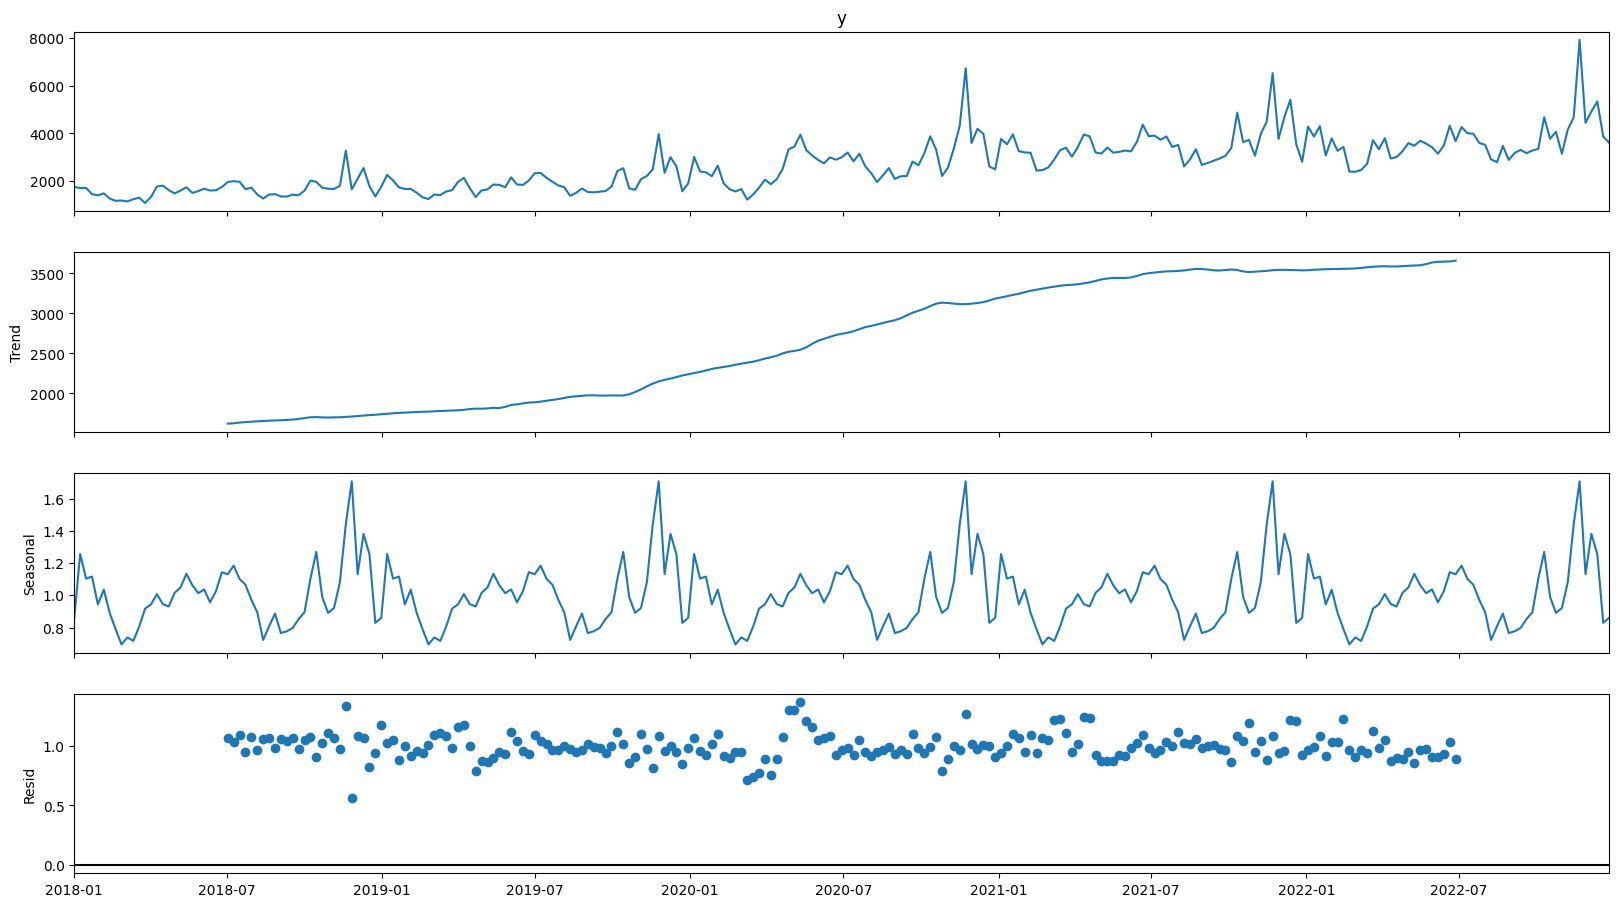

In [16]:
# Decompose the time series into trend, seasonality, and residual.
# We assume a yearly period of 52 weeks for weekly data.
decomposition = seasonal_decompose(df['y'], model='multiplicative', period=52)
fig = decomposition.plot()
fig.set_size_inches(18, 10)
plt.show()

# 52 weeks per year

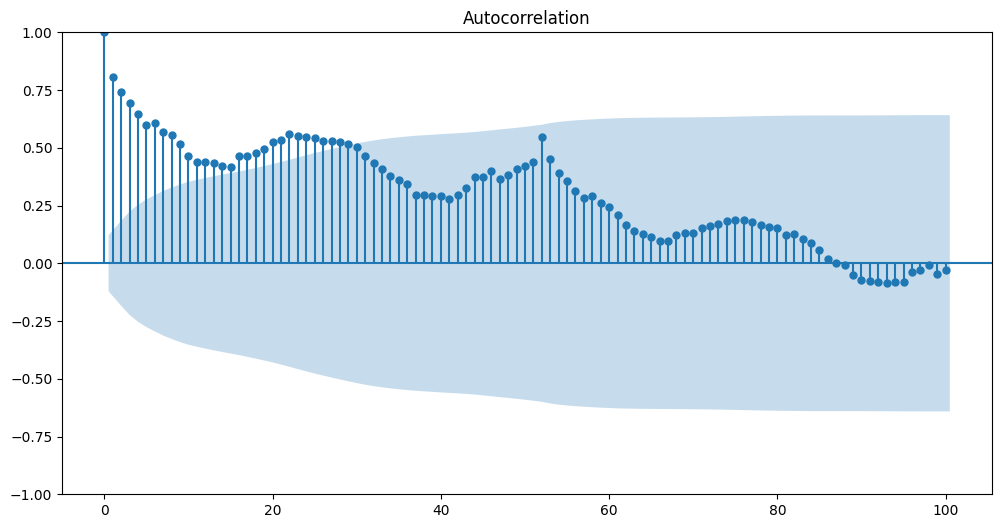

In [ ]:
# ACF plot to see correlation of the series with lagged values
# This graph shows that there is relation with previous lags

fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df['y'], lags=100, ax=ax)
plt.show()

# Train and Test 
Goal to predict for next 13 weeks

In [ ]:
# We want to forecast the next 13 weeks
periods = 13

# Splitting data into train (all but last 13 weeks) and test (last 13 weeks) and take first column (complaints)
train, test = df.iloc[:-periods, 0], df.iloc[-periods:, 0]

# Holt Winters AKA Triple Exponential Smoothing

In [23]:
# Build the Holt-Winters model with both trend and seasonality
# Using seasonal_periods=52 for weekly data since the season is repeating every year

model_holt = ExponentialSmoothing(
    endog=train,
    trend="add",
    seasonal="mul",
    seasonal_periods=52
).fit()
#print(model_holt.summary())

C:\Users\KE541ZM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [ ]:
# Forecast the next 13 weeks
# To forecast next 13 weeks over train data 

holt_pred = model_holt.forecast(periods)
holt_pred[:5]

2022-10-03    4041.186714
2022-10-10    5040.699866
2022-10-17    3931.982688
2022-10-24    3531.243436
2022-10-31    3441.201948
Freq: W-MON, dtype: float64

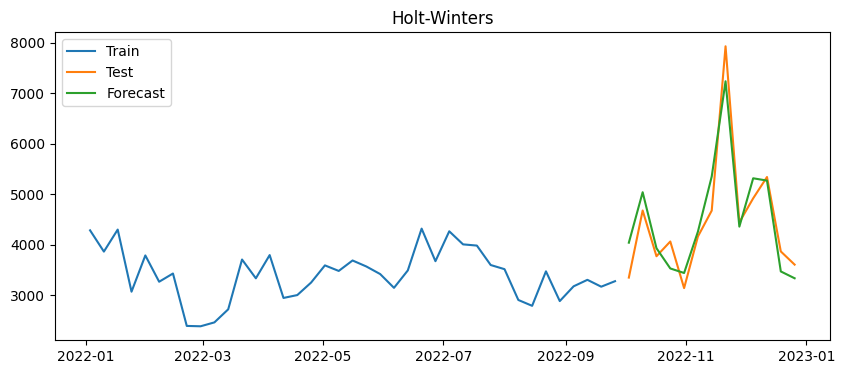

In [21]:
# Plot the Train, Test and Forecast
plt.figure(figsize = (10, 4))

# Plot the train, test and forecast
plt.plot(train.loc['2022'], label = "Train")
plt.plot(test, label = "Test")
plt.plot(holt_pred, label = "Forecast")

# Add a title and legend to the plot
plt.title("Holt-Winters")
plt.legend()
plt.show()

In [22]:
# Evaluate the forecast using RMSE, MAE, MAPE
rmse = root_mean_squared_error(test, holt_pred)
mae = mean_absolute_error(test, holt_pred)
mape = mean_absolute_percentage_error(test, holt_pred)
print(f"RMSE: {rmse:.0f}")
print(f"MAE: {mae:.0f}")
print(f"MAPE: {100 * mape:.1f} %")

RMSE: 425
MAE: 364
MAPE: 8.4 %


# Predict the Future

C:\Users\KE541ZM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


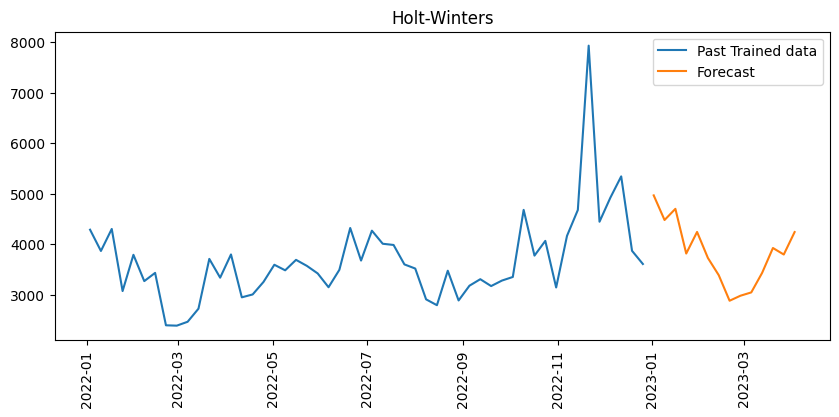

In [41]:
# set the output figure size
plt.figure(figsize = (10, 4))

# Set the period to forecast
period = 14

HWModel = ExponentialSmoothing(endog=df['y'], trend= "add", seasonal="mul",seasonal_periods= 52).fit()

# Forecast using Exponential Smoothing method for 13 weeks
forecasted = HWModel.forecast(period)

# Visual
plt.plot(df['y']['2022'], label="Past Trained data")
plt.plot(forecasted, label="Forecast")
plt.xticks(rotation = 90)

# Add a title and legend to the plot
plt.title("Holt-Winters")
plt.legend()
plt.show()